### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os

### Load Data

In [2]:
# Useful Constants
TRAIN = "./UCI_HAR_Dataset/train/"
TEST = "./UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [3]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [4]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = load_y(y_train_path)
Y_test = load_y(y_test_path)
print(Y_train.shape, Y_test.shape)

(7352, 1) (2947, 1)


#### Plot some samples

In [5]:
X_train_per_class = {}
for c in range(N_CLASSES):
    X_train_per_class[c] = X_train[np.where(Y_train==c)[0],:,:]

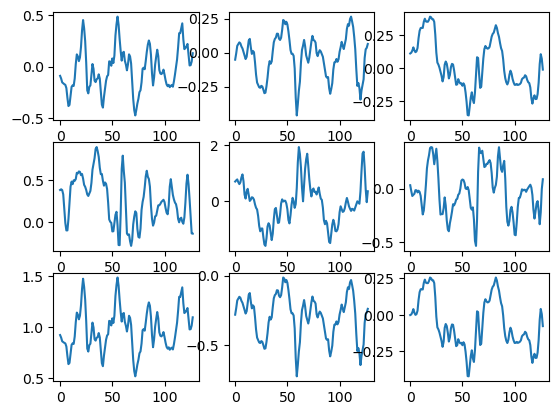

In [6]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [7]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))
maxvalues = np.max(X_train, axis=(0,1))
minvalues = np.min(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))    

print()
for i in range(9):
    print("%7.4f | %7.4f"%(minvalues[i], maxvalues[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578

-1.2322 |  1.2999
-1.3453 |  0.9760
-1.3647 |  1.0669
-4.7337 |  4.1555
-5.9743 |  5.7461
-2.7630 |  2.3660
-0.4666 |  2.1976
-1.5821 |  1.2174
-1.6396 |  1.2814


### Normalization

Can be skipped since the features are all at similar scales aready.

### Utilities

In [8]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [46]:
import sklearn
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]
def confusion_matrix(model, X_test, labels):
    scores = model(X_test)
    predictions = np.argmax(scores, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## Specify and Train Models

Specify a model based on a SimpleRNN (keras.layers.SimpleRNN). 

Start with a model consisting of a single layer. Try different number of units.
Continue with adding more layers. Try to improve the test accuracy. 

In [10]:
import torch
from torch.utils.data import DataLoader
from torchsummary import summary

from sklearn import metrics

In [11]:
nsteps    = X_train.shape[1] # 128 timesteps per series
ninput    = X_train.shape[2] # 9 input features per timestep
nclasses  = 6 # 6 activity classes

print(nsteps, " timesteps, ", ninput, " features, ", nclasses, " activity classes")

128  timesteps,  9  features,  6  activity classes


In [12]:
class ActivityDataset(torch.utils.data.Dataset):
    def __init__(self, X,Y):
        self.nsamples = X.shape[0]
        self.X = X
        self.Y = Y.view(-1).long()

    def __len__(self):
        return self.nsamples

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [13]:
training_set = ActivityDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
test_set = ActivityDataset(torch.Tensor(X_test), torch.Tensor(Y_test))

### Single Layer SimpleRNN

In [15]:
class SequenceClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, h = self.rnn(x)
        return self.linear(h[-1])

In [27]:
class SequenceClassifierLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h,_) = self.rnn(x)
        return self.linear(h[-1])

In [16]:
def train_eval(model, nepochs, batchsize, lr,  training_set, test_set, clipnorm=0.0):
    train_loader = DataLoader(training_set, batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batchsize, shuffle=True)

    train_size = len(train_loader.dataset)
    train_batches = len(train_loader)
    test_size = len(test_loader.dataset)
    test_batches = len(test_loader)

    cross_entropy = torch.nn.CrossEntropyLoss()        
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    cost_train = []
    cost_test = []
    acc_train = []
    acc_test = []

    for epoch in range(nepochs):
        train_loss = 0.0
        train_acc = 0.0
        for (X,y) in train_loader:
            pred = model(X)
            loss = cross_entropy(pred, y)
            train_loss += loss.item()
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
        
            optimizer.zero_grad()
            loss.backward()
            if clipnorm > 0.0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clipnorm)
            optimizer.step()
    
        train_loss /= train_batches
        train_acc /= train_size
        cost_train.append(train_loss)
        acc_train.append(train_acc)
    
        test_loss = 0.0
        test_acc = 0.0
        for (X,y) in test_loader:
            pred = model(X)
            loss = cross_entropy(pred, y)
            test_loss += loss.item()
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
        
        test_loss /= test_batches
        test_acc /= test_size
        cost_test.append(test_loss)
        acc_test.append(test_acc)
        
        print(epoch, train_loss, train_acc, test_loss, test_acc)
    return cost_train, acc_train, cost_test, acc_test

In [48]:
# create and compile model 
hidden_size = 50
nepochs = 25
batchsize=32
lr = 0.0005
clipnorm = 0.1

model = SequenceClassifier(ninput, hidden_size, nclasses)

cost_train, acc_train, cost_test, acc_test = train_eval(model, nepochs, batchsize, lr, training_set, test_set, clipnorm)

0 1.404300680367843 0.4015233949945593 1.27174985601056 0.4448591788259247
1 1.1435826475205628 0.5051686615886833 1.3267633344537468 0.4149983033593485
2 1.0288245387699293 0.566784548422198 1.174171205489866 0.5357991177468612
3 0.934138931657957 0.6217355821545157 1.0840212311795963 0.5856803529012555
4 0.8803299460722053 0.6224156692056583 0.9525540076917217 0.5782151340346114
5 0.7826561510562897 0.6409140369967355 0.9525906440391335 0.6114692908042076
6 0.8229491798774056 0.6285364526659413 0.9810803776146263 0.5948422124194096
7 0.9372389933337336 0.6037812840043526 1.0064700726539857 0.6118086189345097
8 1.045473478410555 0.5417573449401524 1.2711967063206497 0.46216491347132677
9 0.979228152917779 0.5601196953210011 1.192847954329624 0.4886325076348829
10 1.0151195471701415 0.5273394994559304 1.1818902784137315 0.5066168985408891
11 1.0137195045533387 0.5495103373231773 1.2538838578808693 0.4835425856803529
12 0.9834589978922968 0.5765778019586507 1.1867324947029032 0.53512046

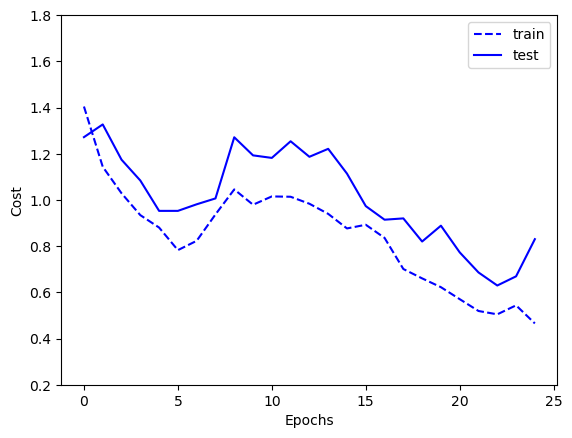

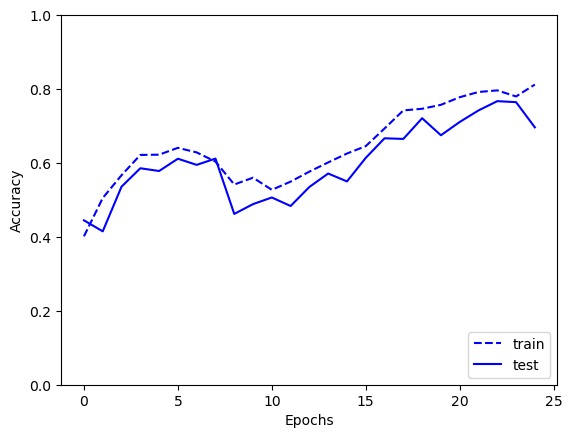

In [49]:
plt.figure(1)
plt.plot(range(nepochs), cost_train, "b--", label="train")
plt.plot(range(nepochs), cost_test, "b-", label="test")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.ylim(0.2,1.8)
plt.legend(loc='upper right')

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b--", label="train")
plt.plot(range(nepochs), acc_test, "b-", label="test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend(loc='lower right')

In [50]:
testsize = len(test_set)
with torch.no_grad():
    X_test, Y_test = next(iter(DataLoader(test_set, batch_size=testsize, shuffle=False)))
    cm = confusion_matrix(model, X_test, Y_test)
    print(cm)

       walk  up  down  sit  stand  lay
walk    290   1   194    2      9    0
up      267  95    93    4     12    0
down     10   0   400    4      6    0
sit       3   0     9  405     74    0
stand    39  14     4  123    352    0
lay       0  16    11    0      0  510


In [51]:
# create and compile model 
hidden_size = 50
nepochs = 25
batchsize=32
lr = 0.0005
clipnorm = 0.1

model = SequenceClassifierLSTM(ninput, hidden_size, nclasses)

cost_train, acc_train, cost_test, acc_test = train_eval(model, nepochs, batchsize, lr, training_set, test_set, clipnorm)

0 1.4815798951231915 0.3589499455930359 1.2509377778217357 0.4645402103834408
1 1.1197171799514605 0.5341403699673558 1.2962062211446865 0.5184933831014591
2 1.002038260905639 0.5813384113166485 1.1180957369906928 0.5395317271801833
3 0.95362091012623 0.581474428726877 1.0280274210437652 0.5690532745164574
4 0.8551794685747313 0.6079978237214363 0.9663574682768955 0.6111299626739056
5 0.8873773800290149 0.594532100108814 1.076456884543101 0.5249406175771971
6 0.9506292781104212 0.5894994559303591 0.9038086133979021 0.6185951815405497
7 0.7693280137103536 0.6678454842219804 0.9347434473294084 0.6277570410587038
8 0.7193315717189208 0.6829434167573449 0.8053808930099652 0.6579572446555819
9 0.6757228949795598 0.7072905331882481 0.8910085424300163 0.6494740413980319
10 0.6592007809359094 0.72810119695321 0.8381096938604949 0.6623685103495079
11 0.5949807287558265 0.7490478781284005 0.815961790341203 0.66270783847981
12 0.5479589381295702 0.7782916213275299 0.822698204107182 0.717678995588

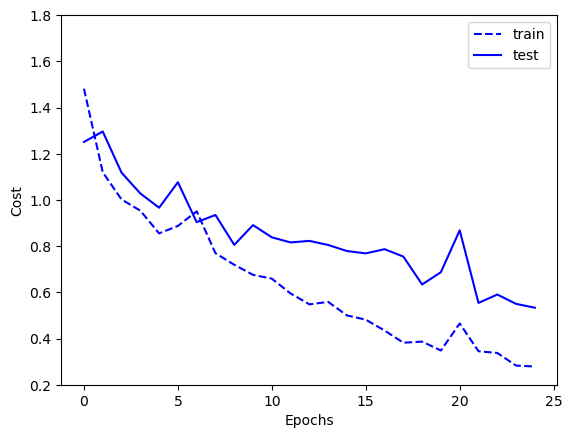

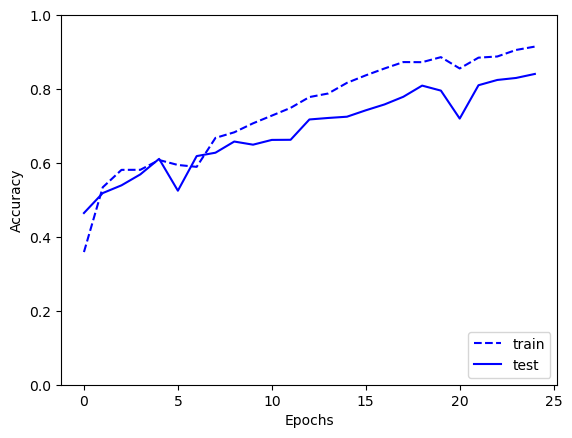

In [52]:
plt.figure(1)
plt.plot(range(nepochs), cost_train, "b--", label="train")
plt.plot(range(nepochs), cost_test, "b-", label="test")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.ylim(0.2,1.8)
plt.legend(loc='upper right')

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b--", label="train")
plt.plot(range(nepochs), acc_test, "b-", label="test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend(loc='lower right')

In [53]:
testsize = len(test_set)
with torch.no_grad():
    X_test, Y_test = next(iter(DataLoader(test_set, batch_size=testsize, shuffle=False)))
    cm = confusion_matrix(model, X_test, Y_test)
    print(cm)

       walk   up  down  sit  stand  lay
walk    374   24    98    0      0    0
up       49  358    62    0      2    0
down      5    1   413    0      1    0
sit       0    4     1  419     66    1
stand     5    9     1  113    404    0
lay       0   27     0    0      0  510


In [56]:
nruns = 3
nepochs = 25
batchsize = 32
lr = 0.0005
nhidden = 50
clipnorm = 0.1

costs_trainc = {}
costs_testc = {}
accs_trainc = {}
accs_testc = {}

torch.manual_seed(0)

for i in range(nruns):
    model = SequenceClassifierLSTM(ninput, nhidden, nclasses)
    cost_train, acc_train, cost_test, acc_test = train_eval(model, nepochs, batchsize, lr,  training_set, test_set, clipnorm=clipnorm)
    costs_trainc[i]=cost_train
    accs_trainc[i]=acc_train
    costs_testc[i]=cost_test
    accs_testc[i]=acc_test


0 1.4715052876783454 0.3714635473340588 1.2737597784688395 0.4533423820834747
1 1.1111205357572307 0.528563656147987 1.0402505324091962 0.5544621649134713
2 0.9816067835559016 0.5982045701849836 1.3032496763813881 0.492704445198507
3 0.9166632364625517 0.6339771490750816 0.9292612790420491 0.6209704784526637
4 0.8339391006075818 0.6467627856365615 0.8558787671468591 0.6416694944010859
5 0.7675468924252883 0.6655331882480957 1.2921842881428298 0.49338310145911096
6 1.0321638402731523 0.5650163220892275 1.0136991681591156 0.5846623685103495
7 0.8857345422972803 0.6171109902067464 0.9297212945517673 0.6053613844587716
8 0.780846793755241 0.6716539717083787 0.8210188893861669 0.663725822870716
9 0.6918264420136161 0.6913764961915125 0.8959437108808949 0.6240244316253818
10 0.6349568350159603 0.7268770402611534 0.8240481852203287 0.6420088225313878
11 0.6593052994945775 0.7227965179542981 0.766435363920786 0.6854428232100441
12 0.6012132390685704 0.7475516866158868 0.7336538767301908 0.7119

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


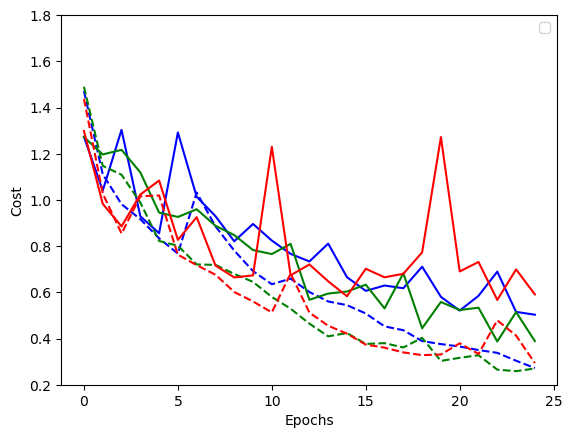

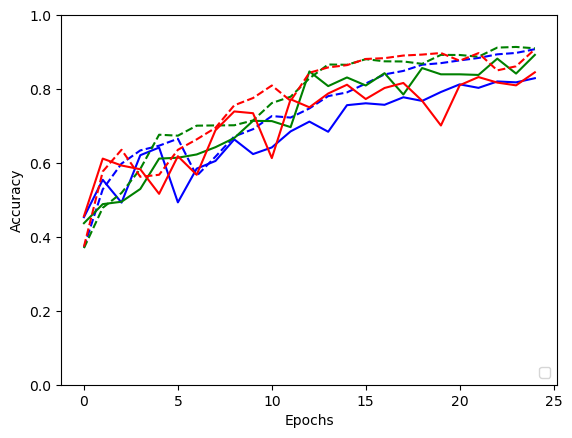

In [59]:
plt.figure(1)
plt.plot(range(nepochs), costs_trainc[0], "b--")
plt.plot(range(nepochs), costs_testc[0], "b-")
plt.plot(range(nepochs), costs_trainc[1], "g--")
plt.plot(range(nepochs), costs_testc[1], "g-")
plt.plot(range(nepochs), costs_trainc[2], "r--")
plt.plot(range(nepochs), costs_testc[2], "r-")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.ylim(0.2,1.8)
plt.legend(loc='upper right')

plt.figure(2)
plt.plot(range(nepochs), accs_trainc[0], "b--")
plt.plot(range(nepochs), accs_testc[0], "b-")
plt.plot(range(nepochs), accs_trainc[1], "g--")
plt.plot(range(nepochs), accs_testc[1], "g-")
plt.plot(range(nepochs), accs_trainc[2], "r--")
plt.plot(range(nepochs), accs_testc[2], "r-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend(loc='lower right')

### Several CNN Layers ('Pure CNN')

In [61]:
#help(torch.nn.Conv1d)

In [78]:
class SequenceClassifierCNN1d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=9, out_channels=16, kernel_size=5, stride=2, padding=0), 
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=0), 
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, stride=2, padding=0),
            torch.nn.ReLU(),
            torch.nn.Flatten())
        self.linear = torch.nn.Linear(320, 10)
        
    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))
        x = self.sequential(x)
        return self.linear(x)

In [79]:
# create and compile model 
nepochs = 25
batchsize=32
lr = 0.0005
clipnorm = -1.0

model = SequenceClassifierCNN1d()
cost_train, acc_train, cost_test, acc_test = train_eval(model, nepochs, batchsize, lr, training_set, test_set, clipnorm)

0 1.0085862764845723 0.5818824809575626 0.6692938942422149 0.7797760434340006
1 0.32929583340883256 0.8737758433079434 0.5716222363614267 0.8473023413640991
2 0.21548077141785105 0.919069640914037 0.44387198664167876 0.8527315914489311
3 0.17383234758415947 0.9318552774755169 0.40434242881113486 0.8703766542246352
4 0.15253285541320624 0.9393362350380848 0.4108379203625905 0.8724126230064473
5 0.13987826485510754 0.9419205658324266 0.40985610572400916 0.8710553104852392
6 0.13528381481908425 0.9438248095756256 0.43889266484847633 0.8819138106549033
7 0.12467955188906711 0.948177366702938 0.48134994122790553 0.8561248727519511
8 0.11831255187482938 0.9506256800870512 0.5013741109199742 0.8758059043094673
9 0.12105999741217364 0.9483133841131665 0.4551902539760215 0.8948082796063793
10 0.11578397260897834 0.9521218715995647 0.5107156386265972 0.8846284356973193
11 0.11335797863809959 0.9491294885745375 0.5739540899552966 0.8944689514760774
12 0.10852520937990884 0.9530739934711643 0.6554

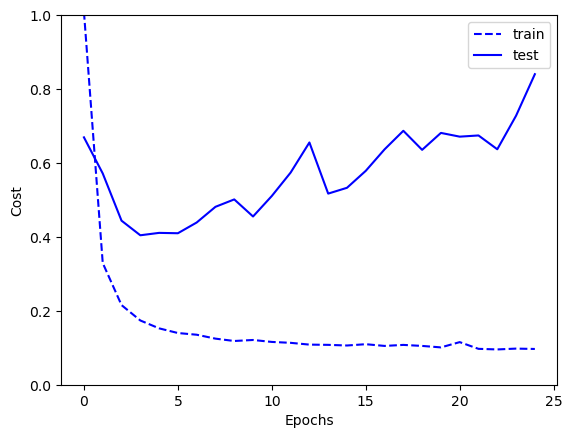

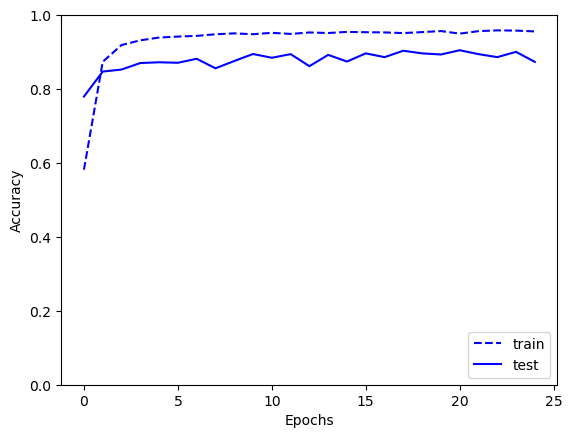

In [81]:
plt.figure(1)
plt.plot(range(nepochs), cost_train, "b--", label="train")
plt.plot(range(nepochs), cost_test, "b-", label="test")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.ylim(0.0,1.0)
plt.legend(loc='upper right')

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b--", label="train")
plt.plot(range(nepochs), acc_test, "b-", label="test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend(loc='lower right')

In [82]:
class SequenceClassifierCNN1dReg(torch.nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=9, out_channels=16, kernel_size=5, stride=2, padding=0), 
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=0),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=0), 
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, stride=2, padding=0),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Flatten())
        self.linear = torch.nn.Linear(320, 10)
        
    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))
        x = self.sequential(x)
        return self.linear(x)

In [87]:
# create and compile model 
nepochs = 25
batchsize=32
lr = 0.0005
clipnorm = -1.0
dropout_rate = 0.2

model = SequenceClassifierCNN1dReg(dropout_rate)
cost_train, acc_train, cost_test, acc_test = train_eval(model, nepochs, batchsize, lr, training_set, test_set, clipnorm)

0 1.1387339261562928 0.49496735582154516 0.8155168378224937 0.6087546657617916
1 0.4874787221784177 0.7898531011969532 0.7009634442867771 0.7841873091279267
2 0.3217194074197956 0.8751360174102285 0.5693072177549844 0.8242280285035629
3 0.24859598696879717 0.9032916213275299 0.46498071153958637 0.8578215134034611
4 0.21680296400318974 0.920429815016322 0.4351818802496118 0.8601968103155752
5 0.18684103145547534 0.9310391730141458 0.43016189484987205 0.8710553104852392
6 0.1686391445605651 0.934575625680087 0.4556858799149913 0.8734306073973532
7 0.15663943756371737 0.9364798694232862 0.43139819911010163 0.8761452324397693
8 0.14718186602644298 0.9387921653971708 0.47535565235121274 0.8724126230064473
9 0.14796155421468227 0.9383841131664853 0.5118760475350584 0.8754665761791652
10 0.1367025377066887 0.9424646354733406 0.46819337445401377 0.8791991856124872
11 0.138678787758007 0.941512513601741 0.44049764208255276 0.8863250763488293
12 0.12560941151383778 0.9454570184983678 0.454847482

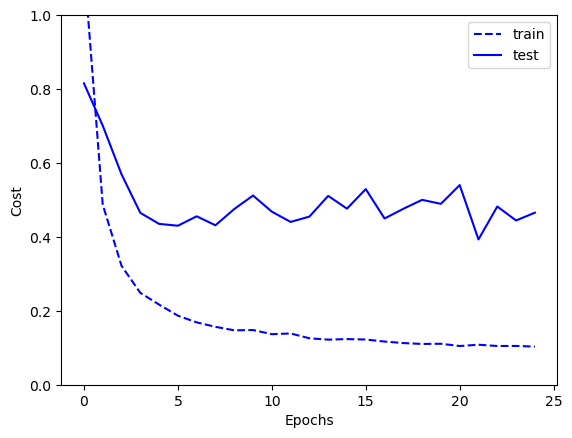

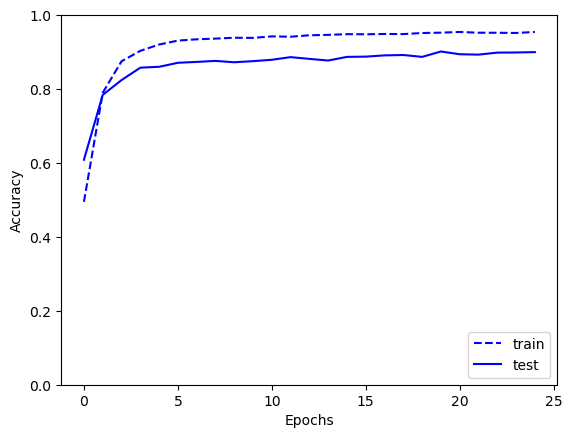

In [88]:
plt.figure(1)
plt.plot(range(nepochs), cost_train, "b--", label="train")
plt.plot(range(nepochs), cost_test, "b-", label="test")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.ylim(0.0,1.0)
plt.legend(loc='upper right')

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b--", label="train")
plt.plot(range(nepochs), acc_test, "b-", label="test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend(loc='lower right')

In [46]:
lr = 0.001
dropout_rate = 0.2

model = torch.nn.model.Sequential(
     torch.nn.Conv1d(in_channels=9, out_channels=16, kernel_size=5, filters=16, kernel_size=(5,1), strides=(2, 1), activation='relu'),
     Dropout(dropout_rate),
     Conv2D(filters=32, kernel_size=(3,1), strides=(2, 1), activation='relu'),
     Dropout(dropout_rate),
     Conv2D(filters=64, kernel_size=(3,1), strides=(2, 1), activation='relu'),
     Dropout(dropout_rate),
     Conv2D(filters=64, kernel_size=(3,1), strides=(2, 1), activation='relu'),
     Flatten(),
     Dense(n_classes, activation='softmax')])

optimizer = Adam(alpha)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### END YOUR CODE 

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 62, 9, 16)         96        
_________________________________________________________________
dropout (Dropout)            (None, 62, 9, 16)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 30, 9, 32)         1568      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 9, 32)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 9, 64)         6208      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 9, 64)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 6, 9, 64)        

In [47]:
batch_size = 64
n_epochs   = 20
xtrain, xtest = X_train.reshape(X_train.shape[0], n_steps, n_input, 1), X_test.reshape(X_test.shape[0], n_steps, n_input,1)
log = model.fit(xtrain, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(xtest, Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 14s 2ms/sample - loss: 0.6127 - accuracy: 0.7406 - val_loss: 0.4920 - val_accuracy: 0.7974
Epoch 2/20
7352/7352 [==============================] - 13s 2ms/sample - loss: 0.2774 - accuracy: 0.8867 - val_loss: 0.4261 - val_accuracy: 0.8514
Epoch 3/20
7352/7352 [==============================] - 13s 2ms/sample - loss: 0.2332 - accuracy: 0.9097 - val_loss: 0.3607 - val_accuracy: 0.8748
Epoch 4/20
7352/7352 [==============================] - 13s 2ms/sample - loss: 0.1872 - accuracy: 0.9275 - val_loss: 0.3274 - val_accuracy: 0.8846
Epoch 5/20
7352/7352 [==============================] - 14s 2ms/sample - loss: 0.1723 - accuracy: 0.9327 - val_loss: 0.2918 - val_accuracy: 0.8955
Epoch 6/20
7352/7352 [==============================] - 14s 2ms/sample - loss: 0.1569 - accuracy: 0.9382 - val_loss: 0.2789 - val_accuracy: 0.9111
Epoch 7/20
7352/7352 [==============================] - 15s 2ms/sample

Train accuracy (end): 0.9654516
Train accuracy (max): 0.96735585
Test accuracy (end) : 0.94061756
Test accuracy (max) : 0.94061756


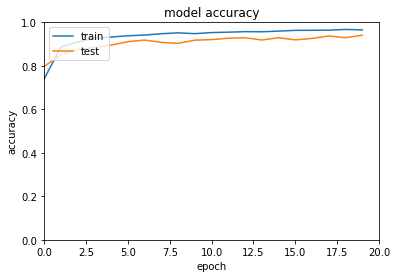

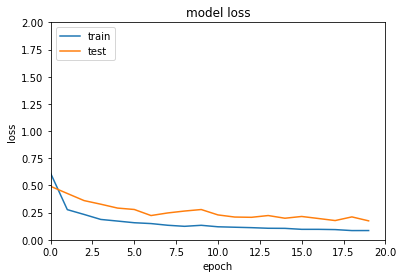

walk   up  down  sit  stand  lay
walk    490    2     4    0      0    0
up        8  453    10    0      0    0
down      6   14   400    0      0    0
sit       0    1     1  389    100    0
stand     0    0     0   29    503    0
lay       0    0     0    0      0  537

In [50]:
performance_plots(model, xtest, Y_test, log, n_epochs)
confusion_matrix(model, xtest, Y_test)

### Mixed CNN and RNN

In [99]:
alpha = 0.001

model = tf.keras.Sequential(
    [InputLayer(input_shape=(128, 9, 1)),
     Conv2D(filters=16, kernel_size=(5,1), strides=(2, 1), activation='relu'),
     Conv2D(filters=32, kernel_size=(3,1), strides=(2, 1), activation='relu'),
     Reshape(((30,9*32))),
     SimpleRNN(units=n_hidden, return_sequences=False),
     Dense(n_classes, activation='softmax')])

optimizer = Adam(alpha)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, \
              metrics=['accuracy'])
model.summary()


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 62, 9, 16)         96        
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 30, 9, 32)         1568      
_________________________________________________________________
reshape_2 (Reshape)          (None, 30, 288)           0         
_________________________________________________________________
simple_rnn_23 (SimpleRNN)    (None, 32)                10272     
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 198       
Total params: 12,134
Trainable params: 12,134
Non-trainable params: 0
_________________________________________________________________


In [97]:
batch_size = 64
n_epochs   = 20
xtrain, xtest = X_train.reshape(X_train.shape[0], n_steps, n_input, 1), X_test.reshape(X_test.shape[0], n_steps, n_input,1)
log = model.fit(xtrain, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(xtest, Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 9s 1ms/sample - loss: 0.8557 - accuracy: 0.6975 - val_loss: 0.6254 - val_accuracy: 0.7550
Epoch 2/20
7352/7352 [==============================] - 6s 857us/sample - loss: 0.5234 - accuracy: 0.8150 - val_loss: 0.4961 - val_accuracy: 0.8303
Epoch 3/20
7352/7352 [==============================] - 7s 923us/sample - loss: 0.3913 - accuracy: 0.8686 - val_loss: 0.4843 - val_accuracy: 0.8113
Epoch 4/20
7352/7352 [==============================] - 7s 946us/sample - loss: 0.2954 - accuracy: 0.9049 - val_loss: 0.4237 - val_accuracy: 0.8307
Epoch 5/20
7352/7352 [==============================] - 7s 981us/sample - loss: 0.2387 - accuracy: 0.9178 - val_loss: 0.4504 - val_accuracy: 0.8263
Epoch 6/20
7352/7352 [==============================] - 7s 992us/sample - loss: 0.2093 - accuracy: 0.9283 - val_loss: 0.4203 - val_accuracy: 0.8439
Epoch 7/20
7352/7352 [==============================] - 7s 1ms/sam

Train accuracy (end): 0.96055496
Train accuracy (max): 0.96137106
Test accuracy (end) : 0.9178826
Test accuracy (max) : 0.9178826


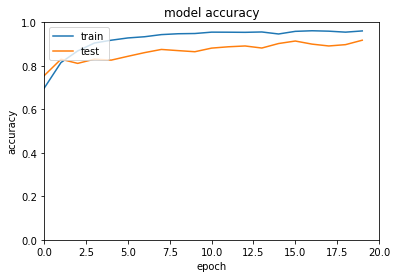

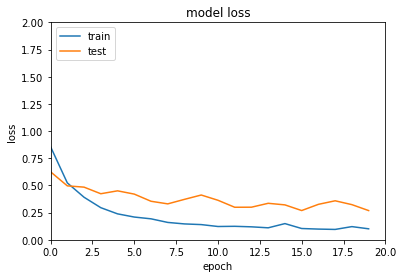

walk   up  down  sit  stand  lay
walk    467    1    28    0      0    0
up        2  439    30    0      0    0
down      9    7   404    0      0    0
sit       0    2     0  417     72    0
stand     0    0     0   91    441    0
lay       0    0     0    0      0  537

In [98]:
performance_plots(model, xtest, Y_test, log, n_epochs)
confusion_matrix(model, xtest, Y_test)

### MLP

In [26]:
alpha = 0.001
rate = 0.5

model = tf.keras.Sequential(
    [InputLayer(input_shape=(128, 9, 1)),
     Flatten(),
     Dense(units=200, activation='relu'),
     Dropout(rate=0.5),
     Dense(units=120, activation='relu'),
     Dropout(rate=0.5),
     Dense(units=60, activation='relu'),
     Dropout(rate=0.5),
     Dense(n_classes, activation='softmax')])

optimizer = Adam(alpha)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, \
              metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               230600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 120)               24120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 60)                7260      
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)               

In [29]:
batch_size = 64
n_epochs   = 50
xtrain, xtest = X_train.reshape(X_train.shape[0], n_steps, n_input, 1), X_test.reshape(X_test.shape[0], n_steps, n_input,1)
log = model.fit(xtrain, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(xtest, Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 1s 192us/sample - loss: 0.2107 - accuracy: 0.9236 - val_loss: 0.6774 - val_accuracy: 0.8829
Epoch 2/50
7352/7352 [==============================] - 1s 198us/sample - loss: 0.1897 - accuracy: 0.9291 - val_loss: 0.8375 - val_accuracy: 0.8751
Epoch 3/50
7352/7352 [==============================] - 2s 205us/sample - loss: 0.1956 - accuracy: 0.9260 - val_loss: 0.6493 - val_accuracy: 0.8985
Epoch 4/50
7352/7352 [==============================] - 2s 206us/sample - loss: 0.1892 - accuracy: 0.9275 - val_loss: 0.7357 - val_accuracy: 0.8819
Epoch 5/50
7352/7352 [==============================] - 2s 212us/sample - loss: 0.1870 - accuracy: 0.9314 - val_loss: 0.8951 - val_accuracy: 0.8721
Epoch 6/50
7352/7352 [==============================] - 2s 207us/sample - loss: 0.1886 - accuracy: 0.9313 - val_loss: 0.7443 - val_accuracy: 0.8870
Epoch 7/50
7352/7352 [==============================] - 2s 212us

Train accuracy (end): 0.92668664
Train accuracy (max): 0.92668664
Test accuracy (end) : 0.890397
Test accuracy (max) : 0.89786226


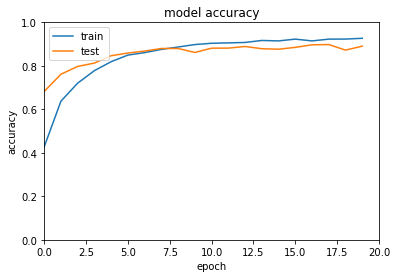

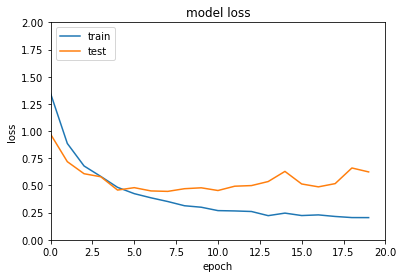

walk   up  down  sit  stand  lay
walk    441   21    32    1      1    0
up        4  443    24    0      0    0
down      5   15   400    0      0    0
sit       0   24     0  373     94    0
stand     1   29     2   70    430    0
lay       0    0     0    0      0  537

In [28]:
performance_plots(model, xtest, Y_test, log, n_epochs)
confusion_matrix(model, xtest, Y_test)